/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solve

Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}

Model Accuracy: 0.679

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.08      0.14        83
           1       0.00      0.00      0.00        11
           2       0.70      0.97      0.81       235
           3       0.00      0.00      0.00        17

    accuracy                           0.68       346
   macro avg       0.27      0.26      0.24       346
weighted avg       0.57      0.68      0.58       346



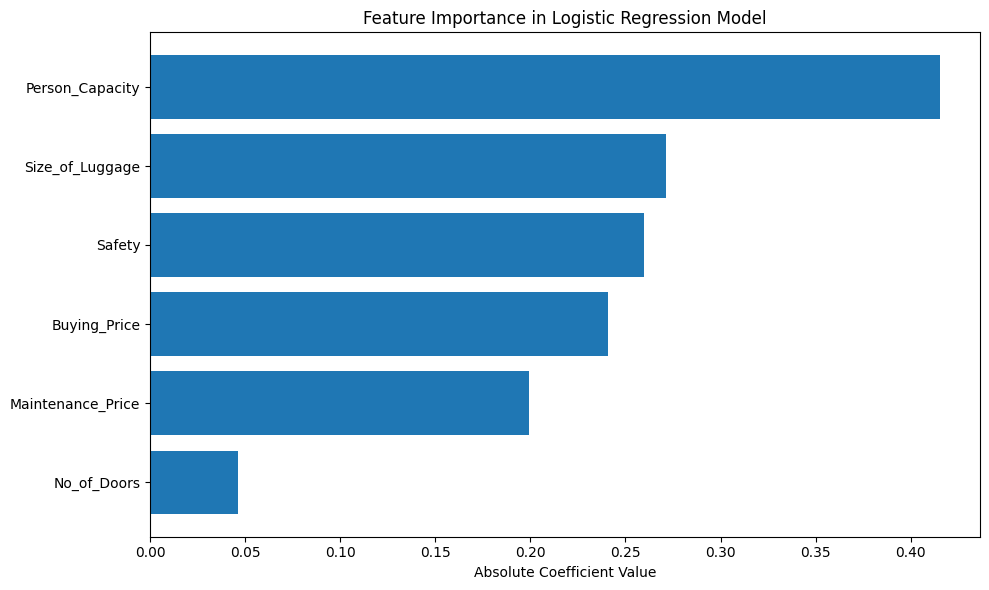

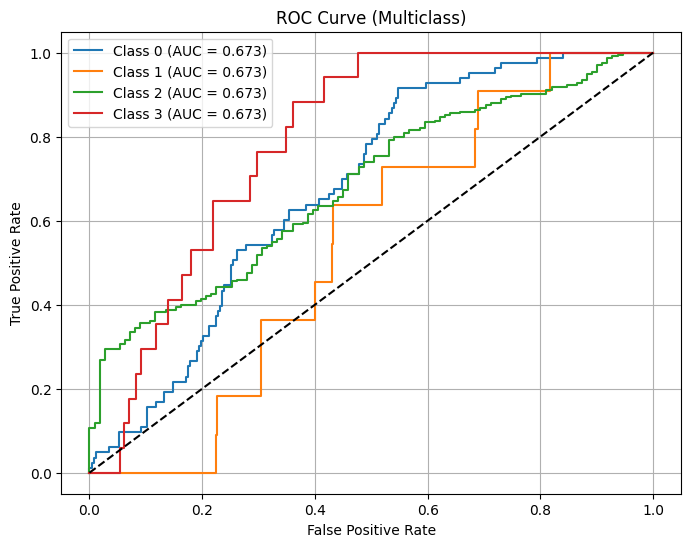

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Loading and Preprocessing
def load_and_preprocess_data(filepath):
    # Load the data
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/car.csv')

    # Initialize label encoder
    le = LabelEncoder()

    # Encode all categorical columns
    categorical_columns = ['Buying_Price', 'Maintenance_Price', 'No_of_Doors',
                         'Person_Capacity', 'Size_of_Luggage', 'Safety']

    X = df.copy()
    for column in categorical_columns:
        X[column] = le.fit_transform(X[column])

    # Encode target variable
    y = le.fit_transform(df['Car_Acceptability'])
    X = X.drop('Car_Acceptability', axis=1)

    return X, y

# 2. Model Training and Evaluation
def train_evaluate_model(X, y):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize base model
    base_model = LogisticRegression(max_iter=1000, random_state=42)

    # Define hyperparameter grid
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear'],
        'penalty': ['l1', 'l2']
    }

    # Perform grid search
    grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get best model
    best_model = grid_search.best_estimator_

    # Make predictions
    y_pred = best_model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    return best_model, X_test, y_test, y_pred, accuracy, class_report, grid_search.best_params_

# 3. Visualization Functions
def plot_feature_importance(model, feature_names):
    plt.figure(figsize=(10, 6))
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': np.abs(model.coef_[0])
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=True)

    plt.barh(range(len(feature_importance)), feature_importance['Importance'])
    plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
    plt.xlabel('Absolute Coefficient Value')
    plt.title('Feature Importance in Logistic Regression Model')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(model, X_test, y_test):
    """Plots the ROC curve for a multiclass classification model.

    Args:
        model: The trained classification model.
        X_test: The test data.
        y_test: The true labels for the test data.
    """
    n_classes = len(np.unique(y_test))  # Get the number of classes
    y_pred_proba = model.predict_proba(X_test)

    plt.figure(figsize=(8, 6))

    # Plot ROC curve for each class
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)

        # Calculate AUC for each class using 'ovr' strategy
        # Pass the entire y_pred_proba to roc_auc_score
        auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', labels=np.unique(y_test))

        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Multiclass)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load and preprocess data
    X, y = load_and_preprocess_data('car.csv')

    # Train and evaluate model
    model, X_test, y_test, y_pred, accuracy, class_report, best_params = train_evaluate_model(X, y)

    # Print results
    print(f"Best Parameters: {best_params}")
    print(f"\nModel Accuracy: {accuracy:.3f}")
    print("\nClassification Report:")
    print(class_report)

    # Generate visualizations
    plot_feature_importance(model, X.columns)
    plot_roc_curve(model, X_test, y_test)